Part 5: Basic Panoramic Image
import numpy.linalg,
import opencv version 4.8.0,

In [31]:
"""
import package, key point match, Ransc, compute_H, pickrandom
"""
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as  linalg
image_1 = cv2.cvtColor(cv2.imread('im01.jpg'), cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(cv2.imread('im02.jpg'), cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(cv2.imread('im03.jpg'), cv2.COLOR_BGR2RGB)
image_4 = cv2.cvtColor(cv2.imread('im04.jpg'), cv2.COLOR_BGR2RGB)
image_5 = cv2.cvtColor(cv2.imread('im05.jpg'), cv2.COLOR_BGR2RGB)
print(image_1.shape, image_2.shape, image_3.shape, image_4.shape, image_5.shape)
sift = cv2.SIFT_create()
kp_1, dp_1 = sift.detectAndCompute(image_1, None)
kp_2, dp_2 = sift.detectAndCompute(image_2, None)
kp_3, dp_3 = sift.detectAndCompute(image_3, None)
kp_4, dp_4 = sift.detectAndCompute(image_4, None)
kp_5, dp_5 = sift.detectAndCompute(image_5, None)

def key_point_match(kp_1, kp_2, dp_1, dp_2):
    key_point_match_12=[]
    key_point_match_21=[]
    match_pairs=[]
    for i in range(len(kp_1)):
        temp_list=[]
        for j in range(len(kp_2)):
            temp=dp_1[i]-dp_2[j]
            temp=np.sqrt(sum(temp**2))
            temp_list.append((temp,j))
        temp_list.sort(key=lambda x: x[0])
        key_point_match_12.append((int(temp_list[0][0]), temp_list[0][1], i))
    for i in range(len(kp_2)):
        temp_list=[]
        for j in range(len(kp_1)):
            temp=dp_2[i]-dp_1[j]
            temp=np.sqrt(sum(temp**2))
            temp_list.append((temp,j))
        temp_list.sort(key=lambda x: x[0])
        key_point_match_21.append((int(temp_list[0][0]), temp_list[0][1], i))
    for i,(d_12,match_2,k_1) in enumerate(key_point_match_12):
        for j,(d_21,match_1,k_2) in enumerate(key_point_match_21):
            if match_2==k_2 and match_1==k_1:
                match_pairs.append((d_12, match_2, k_1))
    return match_pairs

def pick_random(matched_point_set,kp_1,kp_2):
    """
    return 4 random coordinates pairs
    """
    p_kp_1=[]
    p_kp_2=[]
    random= np.random.randint(0, len(matched_point_set),4)
    for r in random:
        index_1, index_2= matched_point_set[r][2], matched_point_set[r][1]
        p_kp_1.append((int(kp_1[index_1].pt[0]),int(kp_1[index_1].pt[1])))
        p_kp_2.append((int(kp_2[index_2].pt[0]),int(kp_2[index_2].pt[1])))
    return p_kp_1,p_kp_2

def compute_H(points_1, points_2, show_H):
    d=len(points_1)
    A = np.zeros([2*d, 9])
    for index ,(point_1, point_2) in enumerate(zip (points_1, points_2)):
        (y_1, x_1),(y_2, x_2)= point_1, point_2
        A[2*index, :]=[x_1, y_1,1,0,0,0,-x_2*x_1, -x_2*y_1, -x_2]
        A[2*index+1, :]=[0,0,0,x_1,y_1,1,-y_2*x_1, -y_2*y_1, -y_2]
    U, D, V= linalg.svd(A)
    H= V [-1, :].reshape(3,3)
    H = H / H[2, 2]
    if show_H is True:
        print(H)
    return H

def Ransac(matched_point_set,image1,image2,diraction,kp_1,kp_2):
    global threshold, iterations
    image_lie=np.zeros([image1.shape[0],image1.shape[1]+image2.shape[1],3],dtype=np.int32)
    # image_lie[:image1.shape[0],:image1.shape[1]]=image1
    # image_lie[:image1.shape[0],image1.shape[1]:]=image2
    in_lie=-1
    for iteration in range (iterations):
        p_1,p_2= pick_random(matched_point_set,kp_1,kp_2)
        if diraction ==2:
           Matrix_H= compute_H(p_2, p_1, False)
        if diraction ==1:
           Matrix_H= compute_H(p_1, p_2, False)
        candidates=[]
        for match_point in matched_point_set:
            (_, k_2, k_1) = match_point
            y_1,x_1= int(kp_1[k_1].pt[0]), int(kp_1[k_1].pt[1])
            y_2,x_2= int(kp_2[k_2].pt[0]), int(kp_2[k_2].pt[1])
            if diraction==2:
               temp= np.dot(Matrix_H, [x_2,y_2,1])
               x_h, y_h, _ = temp/temp[2]
               diff= (x_h-x_1)**2+(y_h-y_1)**2
            if diraction==1:
               temp= np.dot(Matrix_H, [x_1,y_1,1])
               x_h, y_h, _ = temp/temp[2]
               diff= (x_h-x_2)**2+(y_h-y_2)**2
            candidates.append((k_2, k_1, np.sqrt(diff)))
        new_candidates= list (filter(lambda x: x[2]<=threshold,candidates))
        if len(new_candidates)>in_lie:
           in_lie= len(new_candidates)
           inlie_match=new_candidates
           inlie_H= Matrix_H
    # for i in inlie_match:
    #     (k_2,k_1,_)=i
    #     color= np.random.randint(0, 255, 3, dtype=np.int32)
    #     cv2.lie(image_lie,(int(kp_1[k_1].pt[0]),int(kp_1[k_1].pt[1])),(image_1.shape[1]+(int(kp_2[k_2].pt[0])),int(kp_2[k_2].pt[1])),(int(color[0]),int(color[1]),3),1)
        
    return image_lie, inlie_match, inlie_H 


def transform_h_2_h(h_1, h_2,cv_p1,cv_p2,show_H,compute,external_H):
    m_list=[]
    n_list=[]
    x,y,z= h_1.shape
    u,v,w= h_2.shape
    if compute is False:
       Matrix_H= external_H
    elif compute is True: Matrix_H= compute_H(cv_p1, cv_p2, show_H)
    corners= [(0,0),(x-1,0),(x-1,y-1),(0,y-1)]
    for corner in corners:
        m,n= corner
        temp= np.dot(Matrix_H,np.array([m, n, 1]))
        temp_m, temp_n,_ =temp/temp[2]
        m_list.append(int(temp_m))
        n_list.append(int(temp_n))
    max_u,max_v,shift_u,shift_v=int(max(m_list)), int(max(n_list)), int (min(m_list)), int(min(n_list)) 
    print(max_u,max_v,shift_u,shift_v)
    image= np.zeros([max_u-shift_u,max_v-shift_v,3],dtype=np.uint32)
    row=0
    while row<x:
        col=0
        while col < y:
            temp= np.dot(Matrix_H, np.array([row, col, 1]))
            temp_x, temp_y,_= temp/temp[2]
            if shift_u<=temp_x<max_u and shift_v<=temp_y<max_v:
                image[int(temp_x)-shift_u,int(temp_y)-shift_v,:]= h_1[int(row), int(col),:]
            col+=0.2
        row+=0.2
    return image, shift_u,shift_v


(480, 640, 3) (480, 640, 3) (480, 640, 3) (480, 640, 3) (640, 480, 3)


698 347 -157 -712


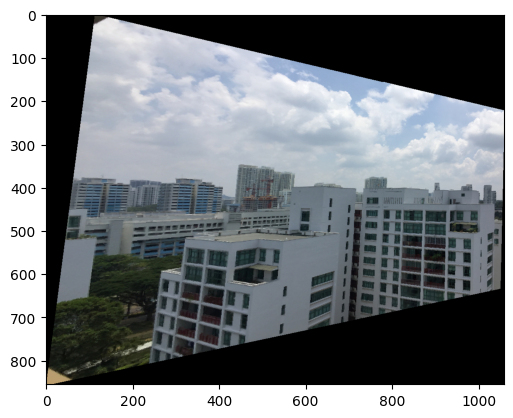

In [2]:
threshold,iterations=0.7, 15000
match_pairs12= key_point_match(kp_1,kp_2, dp_1, dp_2)
image_inlie, inlie_match, H1=Ransac(match_pairs12,image_1,image_2,1,kp_1,kp_2)
image_1_2, shift_h1, shift_w1=transform_h_2_h(image_1,image_2,None,None,False,False,H1)
plt.imshow(image_1_2)


(1536, 3360, 3)


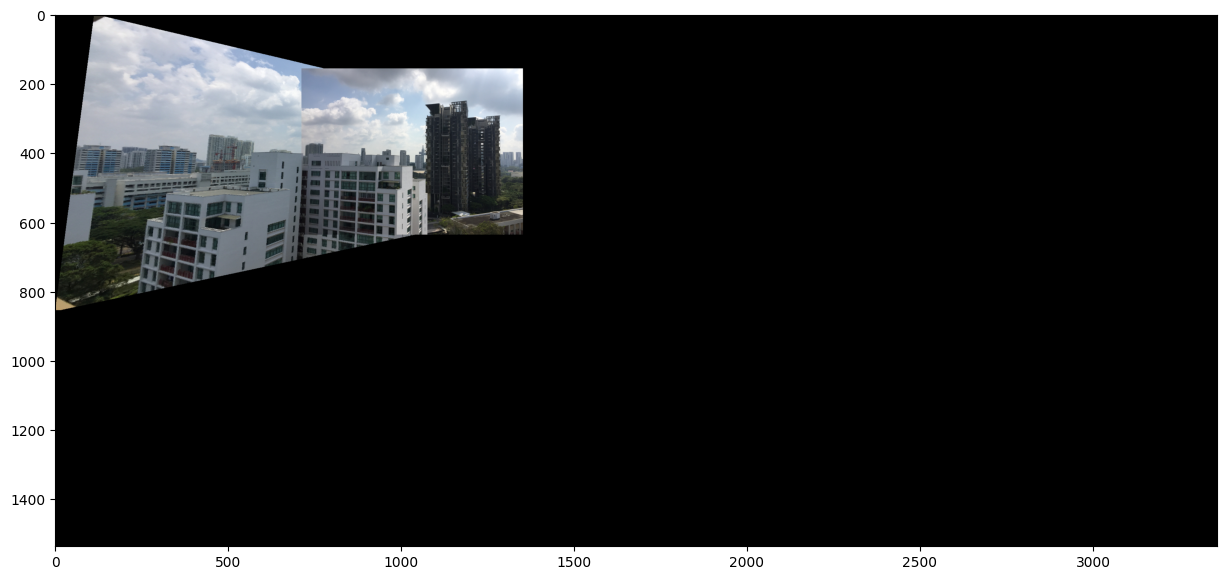

In [53]:
def stitch_image(image_1, image_stitched,shift_h, shift_w,diraction):
    h, w, _ = image_1.shape
    h_s, w_s, _=image_stitched.shape
    h_res, w_res= int (2.4*image_5.shape[0]), 7*image_5. shape[1]
    image_res = np.zeros((h_res, w_res, 3), dtype=np.int32)
    print(image_res.shape)
    if diraction==1:
       for row in range(h_s):
             for col in range(w_s):
                 if not np.all(image_stitched[row,col]==[0,0,0]):
                      image_res[row][col]=image_stitched[row][col]
       for row in range (h):
             for col in range (w):
                 if not np.all(image_1[row,col]==[0,0,0]):
                      image_res[abs(shift_h)+row][abs(shift_w)+col]=image_1[row][col]
       return image_res
    if diraction==2:
          for row in range (h):
             for col in range (w):
                 if not np.all(image_1[row,col]==[0,0,0]):
                     image_res[row][col]=image_1[row][col]
          for row in range(h_s):
             for col in range(w_s):
                 if not np.all(image_stitched[row,col]==[0,0,0]):
                      image_res[abs(shift_h)+row][abs(shift_w)+col]=image_stitched[row][col]
          return image_res
image_res_1_2=stitch_image(image_2, image_1_2, shift_h1, shift_w1,1) 
plt.figure(figsize=(15,15))
plt.imshow(image_res_1_2)

581 900 -23 166


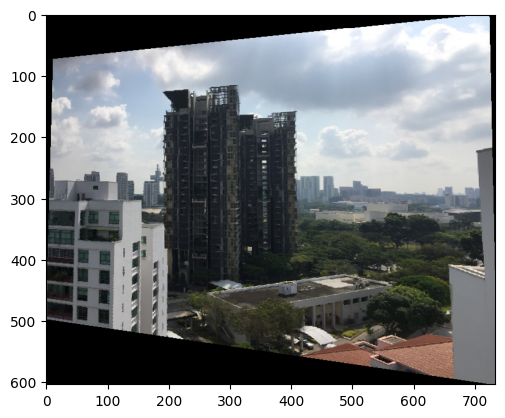

In [4]:
match_pairs23= key_point_match(kp_2,kp_3, dp_2,dp_3)
image_inlie, inlie_match, H2=Ransac(match_pairs23,image_2,image_3,2,kp_2,kp_3)
image_3_2, shift_h2, shift_w2=transform_h_2_h(image_3,image_2,None,None,False,False,H2)
plt.imshow(image_3_2)

(1536, 3360, 3)


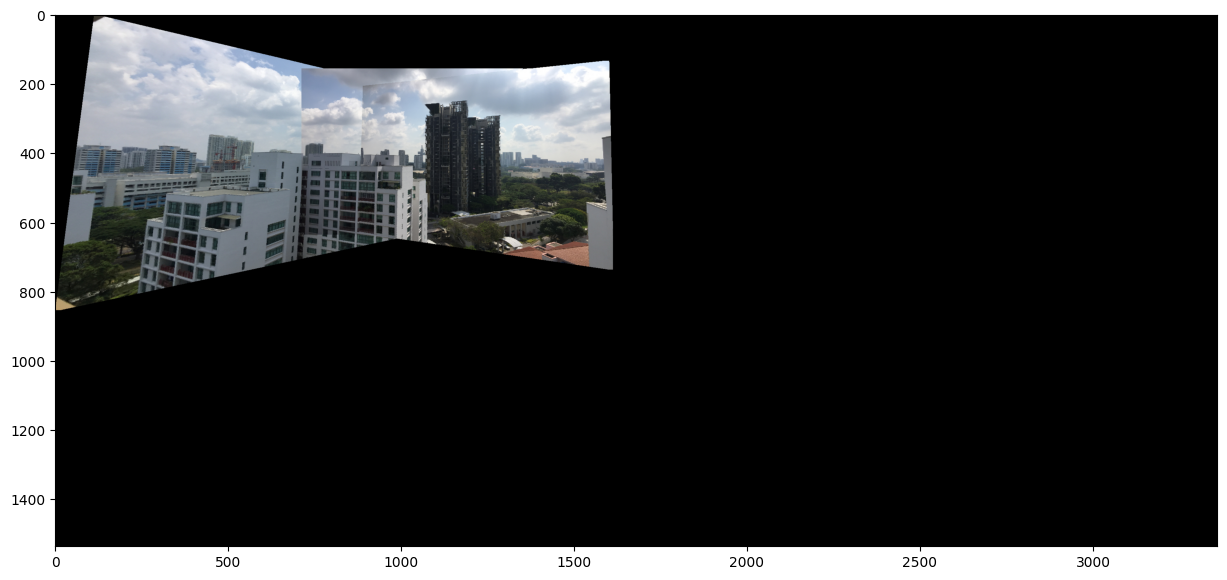

In [54]:
image_res_3_2=stitch_image(image_res_1_2, image_3_2, abs(shift_h2)-abs(shift_h1), shift_w2-shift_w1,2) 
plt.figure(figsize=(15,15))
plt.imshow(image_res_3_2)

636 1139 -125 261


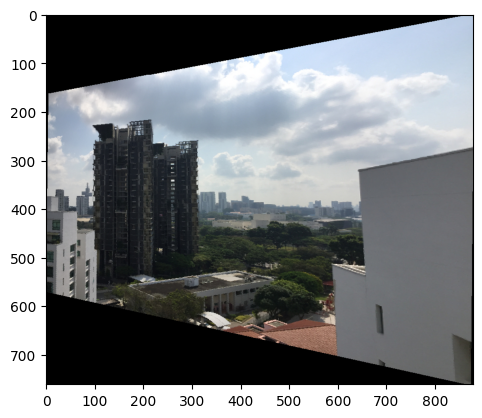

In [9]:
match_pairs24= key_point_match(kp_2,kp_4, dp_2,dp_4)
image_inlie, inlie_match, H3=Ransac(match_pairs24,image_2,image_4,2,kp_2,kp_4)

image_4_2, shift_h3, shift_w3=transform_h_2_h(image_4,image_2,None,None,False,False,H3)
plt.imshow(image_4_2)

(1536, 3360, 3)


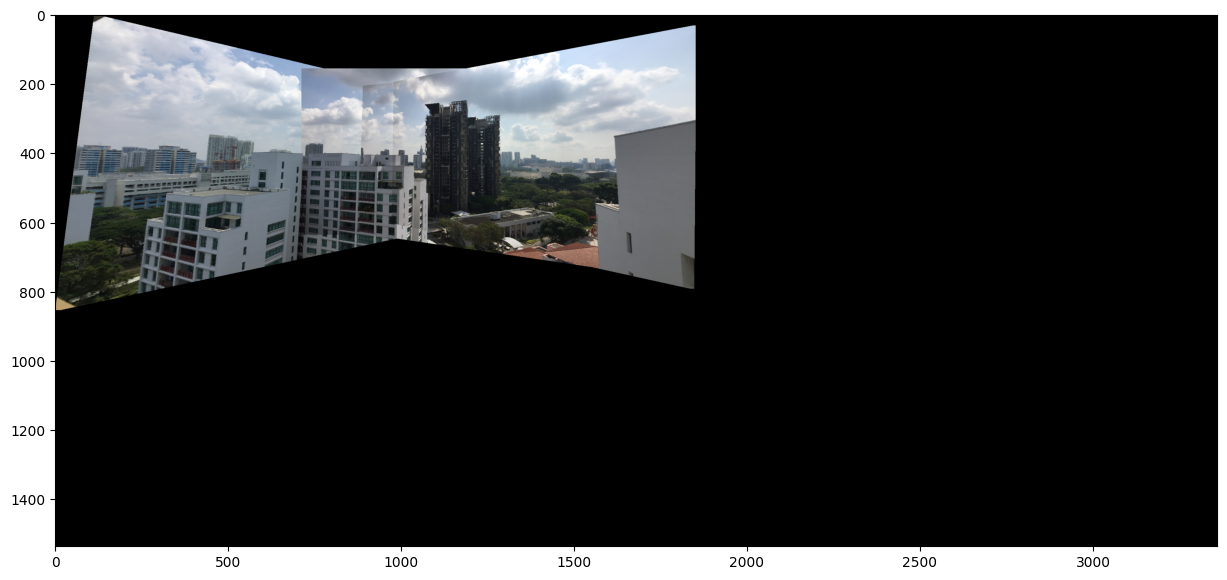

In [55]:
image_res_4_2=stitch_image(image_res_3_2, image_4_2, abs(shift_h3)+shift_h1, abs(shift_w3)-shift_w1,2) 
plt.figure(figsize=(15,15))
plt.imshow(image_res_4_2)

1331 1686 -138 452


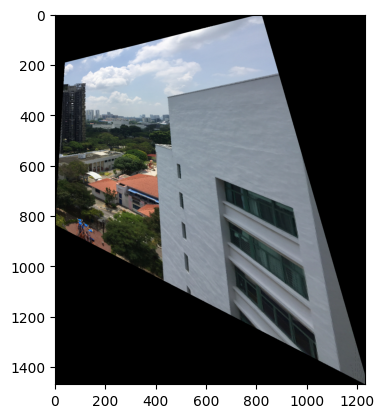

In [78]:
threshold,iterations=0.9, 15000
match_pairs25= key_point_match(kp_2,kp_5, dp_2,dp_5)
image_inlie, inlie_match, H4=Ransac(match_pairs25,image_2,image_5,2,kp_2,kp_5)
image_5_2, shift_h4, shift_w4=transform_h_2_h(image_5,image_2,None,None,False,False,H4)
plt.imshow(image_5_2)

(1664, 3360, 3)


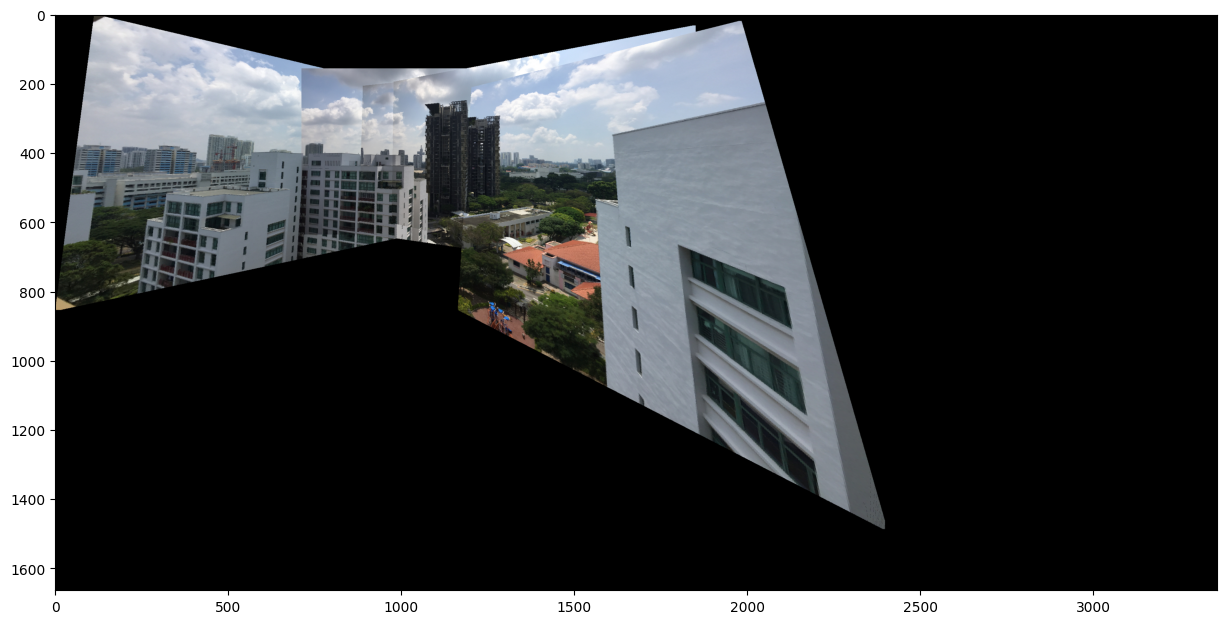

In [79]:
image_res_5_2=stitch_image(image_res_4_2, image_5_2, abs(shift_h4)-abs(shift_h1), abs(shift_w4)-shift_w1,2) 
plt.figure(figsize=(15,15))
plt.imshow(image_res_5_2)